In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

2024-04-16 03:26:49.716834: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
eurusd = pd.read_csv("../../Data/modeldata.csv")

In [4]:
eurud = eurusd.drop(["Unnamed: 0"], axis=1)
X_full, y_tp_full, y_sl_full, close= eurusd[["open", "high", "low", "close", "rsi", "on_balance_volume", "std", "ema_max", "adx"]], eurusd["tp"], eurusd["sl"], eurusd["close_shift"]
def prepare_data(X_, y_Sl, y_Tp, n_steps):
    X, y_tp, y_sl, y = [], [], [], []
    for i in range(len(X_) - n_steps):
        X.append(X_.iloc[i:i+n_steps, :])
        y_tp.append(y_Tp.iloc[i+n_steps])
        y_sl.append(y_Sl.iloc[i+n_steps])
        y.append(close.iloc[i+n_steps])
    return np.array(X), np.array(y_tp), np.array(y_sl),np.array(y)
X, y_tp, y_sl,y = prepare_data(X_full, y_sl_full, y_tp_full, 24)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:

n_steps = 24
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=3,return_sequences=True, activation='relu', input_shape=(n_steps, 9)),
    tf.keras.layers.LSTM(units=3,return_sequences=True, activation='relu'),
	tf.keras.layers.LSTM(units=3, return_sequences=False),
    tf.keras.layers.Dense(units=1)
])

/opt/miniconda3/envs/dataDibe/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
X_train.shape

(48930, 24, 9)

In [21]:
y_train.shape

(48930,)

In [7]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 75s 53ms/step - loss: 0.3816 - val_loss: 0.0112
Epoch 2/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 51s 42ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 3/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 60s 49ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 4/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 73s 60ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 5/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 70s 57ms/step - loss: 0.0109 - val_loss: 0.0113
Epoch 6/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 100s 82ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 7/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 88s 72ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 8/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 148s 77ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 9/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 73s 59ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 10/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 76s 62ms/step - loss: 0.0110 - val_loss: 0.0112


In [11]:
import tf2onnx
onnx_model, _ = tf2onnx.convert.from_keras(model)
with open("eurusd1h_lstm.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

2024-01-20 02:33:41.659382: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2024-01-20 02:33:42.103488: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)


In [8]:
predict = model.predict(X_test)

656/656 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step


In [9]:
X_test.shape

(20970, 24, 9)

In [19]:
mean_squared_error(y_test, predict)

0.010943528001673338

In [12]:
predict.shape

(20970, 1)

In [11]:
y_test.shape

(20970,)

In [14]:
predict = [item for sublist in predict for item in sublist]
error = y_test - predict

In [15]:
error

array([-0.01757422, -0.01228422, -0.07090422, ...,  0.10509578,
       -0.07274422, -0.07998422])

In [57]:
pd.unique(y_test)

array([1.17747, 1.18503, 1.12763, ..., 1.41614, 1.3028 , 1.12239])

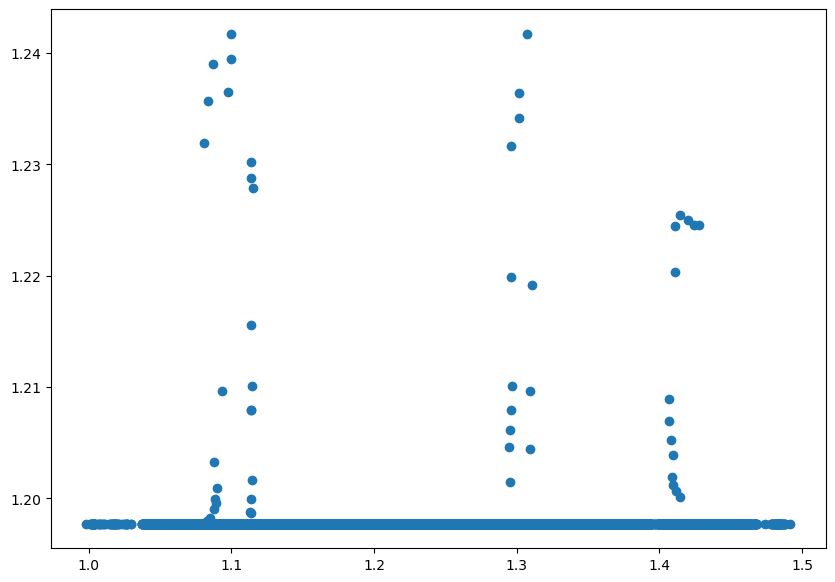

In [16]:
plt.figure(figsize=(10, 7))
plt.scatter(y_test, predict)

(array([ 210., 2690., 6217., 3428., 1943., 1361., 2367., 1946.,  559.,
         249.]),
 array([-0.19966422, -0.15028922, -0.10091422, -0.05153922, -0.00216422,
         0.04721078,  0.09658578,  0.14596078,  0.19533578,  0.24471078,
         0.29408578]),
 <BarContainer object of 10 artists>)

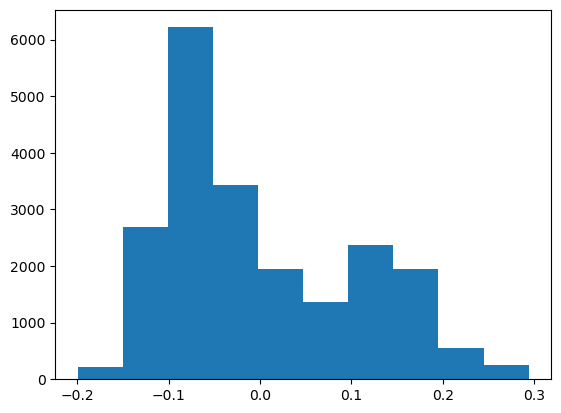

In [18]:
plt.hist(error)